In [1]:
import os

import pandas as pd
import numpy as np

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, FMClassifier
from pyspark.ml import Pipeline, PipelineModel
from sim4rec.modules import Simulator

from replay.metrics import NDCG, Precision, RocAuc, Metric
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from replay.data_preparator import Indexer

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import evaluate_synthetic, EvaluateMetrics
from sim4rec.response import ParametricResponseFunction, BernoulliResponse, NoiseResponse

from replay.models import UCB, ItemKNN
from replay.models import RandomRec
from replay.splitters import RandomSplitter

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '256g')\
    .config('spark.driver.maxResultSize', '256g')\
    .getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

def calc_metric(response_df):
    return response_df.groupBy("user_idx").agg(sf.sum("response").alias("num_positive")).select(sf.mean("num_positive")).collect()[0][0]

/home/syudosaev/anaconda3/envs/sim4rec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


24/04/21 13:24:58 WARN Utils: Your hostname, ecs-syudosaev-big resolves to a loopback address: 127.0.1.1; using 10.11.12.124 instead (on interface eth0)
24/04/21 13:24:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/21 13:24:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
users_df = spark.read.parquet('preprocessed/users.parquet')
items_df = spark.read.parquet('preprocessed/items.parquet')
log_df   = spark.read.parquet('preprocessed/rating.parquet')

items_df = items_df.dropDuplicates(subset=['item_idx'])
users_df = users_df.dropDuplicates(subset=['user_idx'])
log_df = log_df.dropDuplicates(subset=['user_idx', 'item_idx'])

# users_df = users_df.withColumnRenamed("user_idx", "user_id")
# items_df = items_df.withColumnRenamed("item_idx", "item_id")
# log_df = log_df.withColumnRenamed("user_idx", "user_id")
# log_df = log_df.withColumnRenamed("item_idx", "item_id")

# log_df = log_df.join(users_df, log_df['user_idx'] == users_df['user_idx'], 'leftsemi')
# log_df = log_df.join(items_df, log_df['item_idx'] == items_df['item_idx'], 'leftsemi')

for c in users_df.columns[1:]:
    users_df = users_df.withColumnRenamed(c, 'user_' + c)

for c in items_df.columns[1:]:
    items_df = items_df.withColumnRenamed(c, 'item_' + c)

users_df = users_df.cache()
items_df = items_df.cache()
log_df = log_df.cache()

print(users_df.count())
print(items_df.count())
print(log_df.count())

133


85
1161


In [3]:
full_dataframe = log_df.join(items_df, on='item_idx', how='inner').join(users_df, on='user_idx', how='inner').drop('timestamp')
train_df, test_df = RandomSplitter(test_size=0.3, seed=9, drop_cold_items=True, drop_cold_users=True).split(full_dataframe)

In [4]:
avg_item_ratings = full_dataframe.select('item_idx', 'relevance').groupBy('item_idx').agg(sf.mean("relevance").alias('item_rating_avg'))
test_df = test_df.join(avg_item_ratings, on='item_idx', how='inner')
train_df = train_df.join(avg_item_ratings, on='item_idx', how='inner')

In [5]:
train_df.toPandas().to_parquet('preprocessed/train.parquet', index=False)
test_df.toPandas().to_parquet('preprocessed/test.parquet', index=False)

In [6]:
train_df = train_df.withColumn('relevance', sf.when(sf.col('relevance') >= 1, 1).otherwise(0))
test_df = test_df.withColumn('relevance', sf.when(sf.col('relevance') >= 1, 1).otherwise(0))

In [7]:
item_svd = spark.read.csv('item_svd.csv', header=True, inferSchema=True)
user_svd = spark.read.csv('user_svd.csv', header=True, inferSchema=True)

train_df = train_df.join(item_svd, on='item_idx', how='inner')
train_df = train_df.join(user_svd, on='user_idx', how='inner')

test_df = test_df.join(item_svd, on='item_idx', how='inner')
test_df = test_df.join(user_svd, on='user_idx', how='inner')

In [8]:
print('train statistics')
print(train_df.count())
print(train_df.select('user_idx').distinct().count())
print(train_df.select('item_idx').distinct().count())
print(train_df.count() / (train_df.select('user_idx').distinct().count() * train_df.select('item_idx').distinct().count()))
print()

print('test statistics')
print(test_df.count())
print(test_df.select('user_idx').distinct().count())
print(test_df.select('item_idx').distinct().count())
print(test_df.count() / (test_df.select('user_idx').distinct().count() * test_df.select('item_idx').distinct().count()))

train statistics
537
128
84
0.04994419642857143

test statistics
194
93
69
0.03023219573009194


In [9]:
# train statistics
# 537
# 128
# 84
# 0.04994419642857143

# test statistics
# 194 
# 93
# 69
# 0.03023219573009194

In [10]:
va = VectorAssembler(
    inputCols=item_svd.columns[1:] + user_svd.columns[1:] + users_df.columns[1:] + items_df.columns[1:],
    outputCol='features'
)

fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

vee = VectorElementExtractor(inputCol='proba', outputCol='scores', index=1)
mc = ParametricResponseFunction(inputCols=['scores'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline_lr = Pipeline(stages=[va, lr, vee, mc, br])
pipeline_rf = Pipeline(stages=[va, rf, vee, mc, br])
pipeline_fm = Pipeline(stages=[va, fm, vee, mc, br])

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='scores')
br = BernoulliResponse(inputCol='scores', outputCol='response')
pipeline_rand = Pipeline(stages=[noise_resp, br])

lr_model = pipeline_lr.fit(train_df)
rf_model = pipeline_rf.fit(train_df)
fm_model = pipeline_fm.fit(train_df)
rand_model = pipeline_rand.fit(train_df)

In [11]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

def get_baseline(test_df):
    test_df = test_df.select('item_rating_avg', 'relevance').toPandas()
    test_df['baseline'] = (test_df['item_rating_avg']-test_df['item_rating_avg'].min())/(test_df['item_rating_avg'].max()-test_df['item_rating_avg'].min())
    test_df['baseline_bin'] = np.where(test_df['baseline'] > 0.5, 1, 0) 
    print(f"ROC AUC (baseline): {roc_auc_score(test_df.relevance, test_df.baseline)}")
    print(f"Precision (baseline): {precision_score(test_df.relevance, test_df.baseline_bin)}")
    print(f"Recall (baseline): {recall_score(test_df.relevance, test_df.baseline_bin)}")
    print(f"Accuracy (baseline): {accuracy_score(test_df.relevance, test_df.baseline_bin)}")
    print(f"F1 (baseline): {f1_score(test_df.relevance, test_df.baseline_bin)}")
    print()

def assess_models(model, test_df):
    pred_df = model.transform(test_df).select("relevance", "scores").toPandas()
    pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)
    print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
    print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"F1 (classificator): {f1_score(pred_df.relevance, pred_df.response_bin)}")
    print()

get_baseline(test_df)
assess_models(lr_model, test_df)
assess_models(rf_model, test_df)
assess_models(fm_model, test_df)
assess_models(rand_model, test_df)

ROC AUC (baseline): 0.7048992673992674
Precision (baseline): 0.9259259259259259
Recall (baseline): 0.44642857142857145
Accuracy (baseline): 0.4896907216494845
F1 (baseline): 0.6024096385542168



ROC AUC (classificator): 0.7554945054945056
Precision (classificator): 0.925
Recall (classificator): 0.8809523809523809
Accuracy (classificator): 0.8350515463917526
F1 (classificator): 0.9024390243902439

ROC AUC (classificator): 0.7936126373626374
Precision (classificator): 0.865979381443299
Recall (classificator): 1.0
Accuracy (classificator): 0.865979381443299
F1 (classificator): 0.9281767955801106

ROC AUC (classificator): 0.6628891941391941
Precision (classificator): 0.9155844155844156
Recall (classificator): 0.8392857142857143
Accuracy (classificator): 0.7938144329896907
F1 (classificator): 0.8757763975155279

ROC AUC (classificator): 0.48511904761904767
Precision (classificator): 0.8490566037735849
Recall (classificator): 0.5357142857142857
Accuracy (classificator): 0.5154639175257731
F1 (classificator): 0.6569343065693432



In [12]:
# Base features

# ROC AUC (baseline): 0.7048992673992674
# Precision (baseline): 0.9259259259259259
# Recall (baseline): 0.44642857142857145
# Accuracy (baseline): 0.4896907216494845
# F1 (baseline): 0.6024096385542168

# ROC AUC (classificator): 0.7348901098901099
# Precision (classificator): 0.9130434782608695
# Recall (classificator): 0.875
# Accuracy (classificator): 0.8195876288659794
# F1 (classificator): 0.8936170212765957

# ROC AUC (classificator): 0.7649954212454212
# Precision (classificator): 0.865979381443299
# Recall (classificator): 1.0
# Accuracy (classificator): 0.865979381443299
# F1 (classificator): 0.9281767955801106

# ROC AUC (classificator): 0.652014652014652
# Precision (classificator): 0.90625
# Recall (classificator): 0.8630952380952381
# Accuracy (classificator): 0.8041237113402062
# F1 (classificator): 0.8841463414634146

# ROC AUC (classificator): 0.3923992673992674
# Precision (classificator): 0.8478260869565217
# Recall (classificator): 0.4642857142857143
# Accuracy (classificator): 0.4639175257731959
# F1 (classificator): 0.6000000000000001

In [13]:
# All features

# ROC AUC (classificator): 0.7554945054945056
# Precision (classificator): 0.925
# Recall (classificator): 0.8809523809523809
# Accuracy (classificator): 0.8350515463917526
# F1 (classificator): 0.9024390243902439

# ROC AUC (classificator): 0.756868131868132
# Precision (classificator): 0.8704663212435233
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8711340206185567
# F1 (classificator): 0.9307479224376731

# ROC AUC (classificator): 0.6195054945054945
# Precision (classificator): 0.9
# Recall (classificator): 0.8571428571428571
# Accuracy (classificator): 0.7938144329896907
# F1 (classificator): 0.8780487804878048

In [14]:
# Only embeds

# ROC AUC (classificator): 0.6236263736263737
# Precision (classificator): 0.8777777777777778
# Recall (classificator): 0.9404761904761905
# Accuracy (classificator): 0.8350515463917526
# F1 (classificator): 0.9080459770114943

# ROC AUC (classificator): 0.7834249084249084
# Precision (classificator): 0.8870967741935484
# Recall (classificator): 0.9821428571428571
# Accuracy (classificator): 0.8762886597938144
# F1 (classificator): 0.9322033898305085

# ROC AUC (classificator): 0.7065018315018315
# Precision (classificator): 0.9323308270676691
# Recall (classificator): 0.7380952380952381
# Accuracy (classificator): 0.7268041237113402
# F1 (classificator): 0.8239202657807309

In [15]:
full_dataframe = log_df.join(items_df, on='item_idx', how='inner').join(users_df, on='user_idx', how='inner').drop('timestamp')
avg_item_ratings = full_dataframe.select('item_idx', 'relevance').groupBy('item_idx').agg(sf.mean("relevance").alias('item_rating_avg'))
full_dataframe = full_dataframe.withColumn('relevance', sf.when(sf.col('relevance') >= 1, 1).otherwise(0))
full_dataframe = full_dataframe.join(avg_item_ratings, on='item_idx', how='inner')

users_df = users_df.join(user_svd, on='user_idx', how='inner').cache()
items_df = items_df.join(item_svd, on='item_idx', how='inner').cache()

item_generator = RealDataGenerator(label='items_real', seed=42)
user_generator = RealDataGenerator(label='users_real', seed=42)

# передадим популяции пользователей и айтемов
item_generator.fit(items_df)
user_generator.fit(users_df)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(items_df.count())
user_generator.generate(users_df.count())

DataFrame[user_idx: string, user_smoker: bigint, user_weight: bigint, user_height: double, user_drink_level_abstemious: smallint, user_drink_level_casual drinker: smallint, user_drink_level_social drinker: smallint, user_dress_preference_?: smallint, user_dress_preference_elegant: smallint, user_dress_preference_formal: smallint, user_dress_preference_informal: smallint, user_dress_preference_no preference: smallint, user_ambience_?: smallint, user_ambience_family: smallint, user_ambience_friends: smallint, user_ambience_solitary: smallint, user_transport_?: smallint, user_transport_car owner: smallint, user_transport_on foot: smallint, user_transport_public: smallint, user_marital_status_?: smallint, user_marital_status_married: smallint, user_marital_status_single: smallint, user_marital_status_widow: smallint, user_hijos_?: smallint, user_hijos_dependent: smallint, user_hijos_independent: smallint, user_hijos_kids: smallint, user_birth_year_1930: smallint, user_birth_year_1940: smal

In [16]:
indexer = Indexer(user_col='user_idx', item_col='item_idx')
indexer.fit(users=users_df, items=items_df)

dummy_log = pandas_to_spark(pd.DataFrame({'user_idx' : [1], 'item_idx' : [1], 'relevance' : [0.0]}))

ucb_lr = UCB()
ucb_lr.fit(indexer.transform(dummy_log))

ucb_rf = UCB()
ucb_rf.fit(indexer.transform(dummy_log))

ucb_fm = UCB()
ucb_fm.fit(indexer.transform(dummy_log))

ucb_rand = UCB()
ucb_rand.fit(indexer.transform(dummy_log))

In [17]:
evaluator = EvaluateMetrics(
    userKeyCol='user_idx',
    itemKeyCol='item_idx',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 5, Precision() : 5, RocAuc(): 5}
)

def calc_metric(response_df):
    return (response_df
            .groupBy("user_idx").agg(sf.sum("response").alias("num_positive"))
            .select(sf.mean("num_positive")).collect()[0][0]
           )

In [19]:
def do_a_cycle(simul, model, pipeline, iteration, metrics):
    users = simul.sample_users(0.1).dropna().cache()
    log = simul.get_log(user_df=users)
    log = dummy_log if log is None else log
    log = log.cache()

    recs = model.predict(
        log=indexer.transform(log),
        k=1,
        users=indexer.transform(users),
        items=indexer.transform(items_df),
    )
    recs = indexer.inverse_transform(recs).cache()

    resp = simul.sample_responses(
        recs_df=recs, 
        user_features=users,
        item_features=items_df,
        action_models=pipeline
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()
    simul.update_log(resp, iteration=iteration)

    metrics.append(calc_metric(resp))

    model._clear_cache()
    ucb_train_log = simul.log.cache()
    model.fit(log=indexer.transform(
        ucb_train_log.select('user_idx', 'item_idx', 'response').withColumnRenamed('response', 'relevance')
    ))

    log.unpersist()
    users.unpersist()
    recs.unpersist()
    resp.unpersist()
    ucb_train_log.unpersist()

sim_lr = Simulator(user_generator, item_generator, f'checkpoints/lr', None, 'user_idx', 'item_idx', spark)
sim_rf = Simulator(user_generator, item_generator, f'checkpoints/rf', None, 'user_idx', 'item_idx', spark)
sim_fm = Simulator(user_generator, item_generator, f'checkpoints/fm', None, 'user_idx', 'item_idx', spark)
sim_rand = Simulator(user_generator, item_generator, f'checkpoints/rand', None, 'user_idx', 'item_idx', spark)

lr_metrics = []
rf_metrics = []
fm_metrics = []
rnd_metrics = []

for i in range(30):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    do_a_cycle(sim_lr, ucb_lr, lr_model, i, lr_metrics)
    # do_a_cycle(sim_rf, ucb_rf, rf_model, i, rf_metrics)
    # do_a_cycle(sim_fm, ucb_fm, fm_model, i, fm_metrics)
    # do_a_cycle(sim_rand, ucb_rand, rand_model, i, rnd_metrics)
    
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

------------------------Stage 0------------------------


Time of 1 iteration: 
32.479371786117554
------------------------Stage 1------------------------


Time of 2 iteration: 
45.90041780471802
------------------------Stage 2------------------------


Time of 3 iteration: 
44.42529344558716
------------------------Stage 3------------------------


Time of 4 iteration: 
44.81239032745361
------------------------Stage 4------------------------


Time of 5 iteration: 
44.56375598907471
------------------------Stage 5------------------------


Time of 6 iteration: 
45.41217660903931
------------------------Stage 6------------------------


Time of 7 iteration: 
45.316253662109375
------------------------Stage 7------------------------


Time of 8 iteration: 
45.622103691101074
------------------------Stage 8------------------------


Time of 9 iteration: 
44.96225333213806
------------------------Stage 9------------------------


Time of 10 iteration: 
44.900471448898315
------------------------Stage 10------------------------


Time of 11 iteration: 
44.97688579559326
------------------------Stage 11------------------------


Time of 12 iteration: 
46.116472005844116
------------------------Stage 12------------------------


Time of 13 iteration: 
44.613990783691406
------------------------Stage 13------------------------


Time of 14 iteration: 
44.58865165710449
------------------------Stage 14------------------------


Time of 15 iteration: 
44.48060584068298
------------------------Stage 15------------------------


Time of 16 iteration: 
44.61485028266907
------------------------Stage 16------------------------


Time of 17 iteration: 
45.14234113693237
------------------------Stage 17------------------------


Time of 18 iteration: 
44.81842827796936
------------------------Stage 18------------------------


Time of 19 iteration: 
45.275198459625244
------------------------Stage 19------------------------


Time of 20 iteration: 
45.00616407394409
------------------------Stage 20------------------------


Time of 21 iteration: 
44.80604600906372
------------------------Stage 21------------------------


Time of 22 iteration: 
45.954612016677856
------------------------Stage 22------------------------


Time of 23 iteration: 
46.21726632118225
------------------------Stage 23------------------------


Time of 24 iteration: 
45.120391607284546
------------------------Stage 24------------------------


Time of 25 iteration: 
45.35531735420227
------------------------Stage 25------------------------


Time of 26 iteration: 
45.3832049369812
------------------------Stage 26------------------------


Time of 27 iteration: 
45.41691756248474
------------------------Stage 27------------------------


Time of 28 iteration: 
44.87651586532593
------------------------Stage 28------------------------


Time of 29 iteration: 
45.27524971961975
------------------------Stage 29------------------------


Time of 30 iteration: 
45.17724680900574


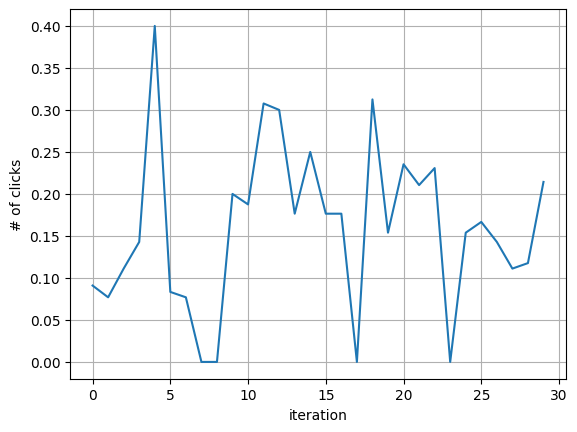

In [20]:
plt.plot(lr_metrics)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('# of clicks')
plt.show()